# What's that Doggy in the Window?
## Data Cleaning and Pre-processing

By: **Bryan Santos**

Have you ever wanted to know the breed of dogs you see in social media or in parks because you found they look suitable for yourself?

This project aims to build an application that lets users upload images of a dog and get its breed. The application will then assess the breed characteristics if it is suitable for the user based on lifestyle. If it is, then the system will redirect the user to a dog of that particular breed that is up for adoption.

The project will utilize multi-class image classification and recommendation systems machine learning models to achieve its goals.

The pet industry is a multi-billion dollar industry even just in the United States alone. The trend of owning pets is on a steady rise. Unfortunately, so do the number of dogs that would be without a permanent home or that would be euthanized. Many people buy dogs because of fad or appearances and abandon them, most likely because they do not realize that dogs of different breeds have unique characteristics and may not necessarily match their lifestyles.

***

This is the third notebook in the project. The purpose of this notebook is to clean and pre-process all the dataset I have gathered through a series of web scraping and API calls.

## 1: Package Imports and Data Load

Below are the packages used to clean the various dataset I have gathered.

In [71]:
import pandas as pd
import numpy as np
import json
import requests
from requests import get
import urllib.request as req
import os, sys, random, string
import tqdm
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [72]:
%%capture

from tqdm import tqdm_notebook as tqdm
from tqdm import tnrange
tqdm().pandas()

Load the dataframe that recorded all of images gathered from various web scrape sessions and API calls. This dataframe should already have the combined images from www.dog.ceo and Udacity.

In [73]:
### Load dataframe
images_df = pd.read_csv('images_df.csv')

In [74]:
### Delete unnecessaru column
del images_df['Unnamed: 0']
images_df.shape

(28669, 2)

In [75]:
images_df.head(5)

,filename,breed
0,yr5nolw2d8qzb9i3scg4.jpg,setter-irish
1,01g4tqhjevrdzo3pl2ky.jpg,setter-irish
2,lhyq7io1ek6gbwuc2tn8.jpg,setter-irish
3,5971pwrfx0hunc3m4el2.jpg,setter-irish
4,o6vqbkigf4n32xmzrls5.jpg,setter-irish


## 2: Data Cleaning

In [76]:
### Get count of unique breeds which will serve as the classes
count_df = images_df.breed.value_counts()

In [77]:
### Convert to dataframe
count_df = pd.DataFrame(count_df)
count_df = count_df.reset_index()
count_df.columns = ['breed', 'count']

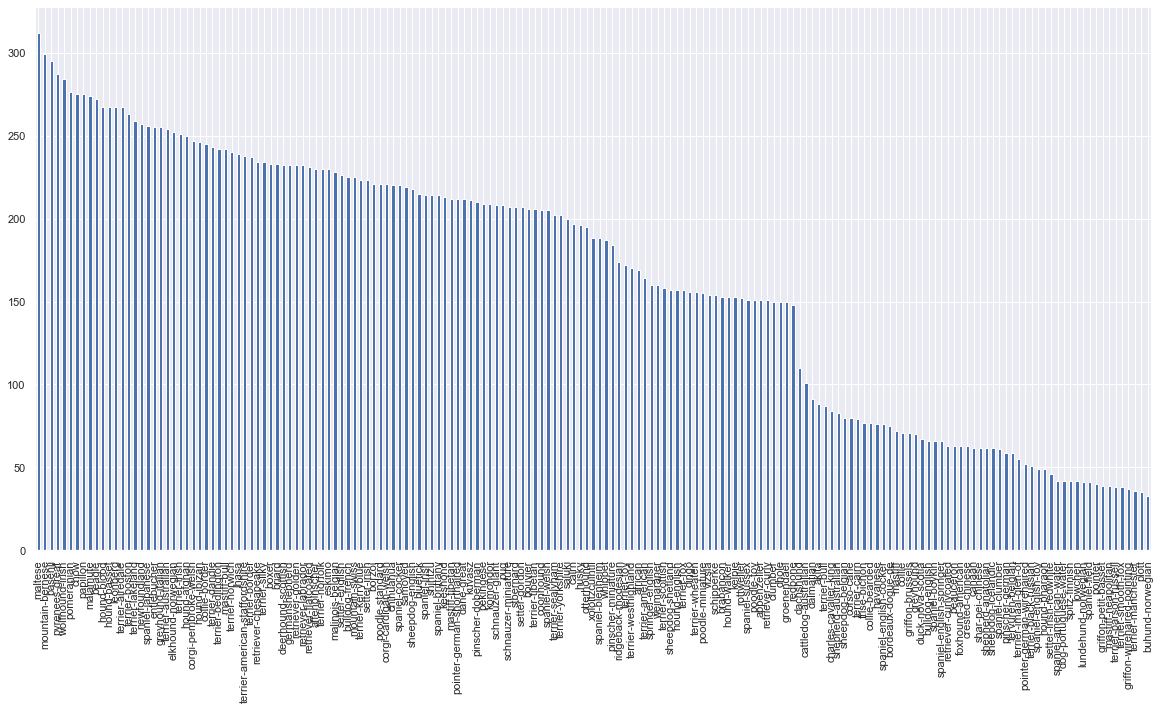

In [29]:
### Quick look at the distribution
images_df["breed"].value_counts().plot.bar(figsize=(20, 10))

The code below is here just in case I need to filter the number of classes I would predict. It is obvious in the visualization that I have a serious **class imbalance** especially when we consider that we have 173 total classes. However,  I want to look at the results of my classification models first before I decide if I will simplify my data my reducing the number of classes, which effectively means reducing the number of images. Transfer Learning may be key in being able to effectively build models on this many classes despite the imbalance. Transfer Learning involves using pre-trained models.

One way to do this is to only include classes that have the count above a certain threshold. The code block below is reserved for this purpose.

In [30]:
### Filter dataset
delete_df = count_df.loc[(count_df['count'] < 50)]

In [31]:
delete_df.shape

(18, 2)

In [32]:
### Validate list
delete_list = delete_df['breed']
delete_list

155            spaniel-english-toy
156                  hound-pharaoh
157          setter-irish-redwhite
158         spaniel-american-water
159           dog-portuguese-water
160                  spitz-finnish
161                        lowchen
162            lundehund-norwegian
163                  spaniel-field
164                        pointer
165           griffon-petit-basset
166             mastiff-neapolitan
167         terrier-parson-russell
168             terrier-smooth-fox
169    griffon-wirehaired-pointing
170             terrier-manchester
171                          plott
172               buhund-norwegian
Name: breed, dtype: object

The code below will be run if it is necessary to delete classes due to lack of images of certain breeds.

In [29]:
### Delete actual folders in the file system

# i = 1

# for folder in delete_list:
    
#     print('[' + str(i) + '] Deleting folder ' + folder)
#     i += 1
    
#     try:
#         shutil.rmtree("images/" + folder + "/")
#     except OSError as e:
#         print ("Error: %s - %s." % (e.filename, e.strerror))

[1] Deleting folder ovcharka-caucasian
[2] Deleting folder mix
[3] Deleting folder dachshund
[4] Deleting folder shiba
[5] Deleting folder cattledog-australian
[6] Deleting folder frise-bichon
[7] Deleting folder akita
[8] Deleting folder pointer-germanlonghair
[9] Deleting folder waterdog-spanish
[10] Deleting folder terrier-patterdale
[11] Deleting folder havanese
[12] Deleting folder mastiff-english
[13] Deleting folder cotondetulear
[14] Deleting folder hound-plott
[15] Deleting folder pitbull
[16] Deleting folder terrier-russell
[17] Deleting folder buhund-norwegian
[18] Deleting folder bulldog-english
[19] Deleting folder australian-shepherd
[20] Deleting folder dalmatian
[21] Deleting folder cockapoo
[22] Deleting folder finnish-lapphund


In [78]:
breed_list = count_df['breed']
breed_list.tail

<bound method NDFrame.tail of 0                          maltese
1                 mountain-bernese
2                          basenji
3                   pyrenees-great
4                  wolfhound-irish
                  ...             
168             terrier-smooth-fox
169    griffon-wirehaired-pointing
170             terrier-manchester
171                          plott
172               buhund-norwegian
Name: breed, Length: 173, dtype: object>

## 3: Pre-Processing

Given that the images were gathered from multiple sources (www.dog.ceo accepts user uploaded images and retained user-specified filenames), some of the filenames include the actual breed of the images. I don't want this to play a factor in the actual classification models which is why I am randomizing the names of each image files.

In [118]:
def do_rename(path):
    '''
    This function checks each file for renaming if they are valid. If
    valid, this runs the create_random_name function to generate the 
    name then does the actual file system renaming.
    
    Parameters:
    - path = image path for renaming
    
    Output:
    - Sets the new randomized filename
    
    '''
    for this in os.listdir(path):
        
        ### Check if valid
        if os.path.isfile(path+this):
            
            ### Get a random name including the previous file extension
            rand = create_random_name(path, os.path.splitext(this)[1])
            
            ### Actual renaming
            os.rename(path+this, path+rand)

        else:
            ### Not a file
            print("\tSkipped:", "'"+this+"'", "Target is not a file")

In [119]:
# Create a random file name and make sure the target file wouldn't exist
def create_random_name(path, ext):
    '''
    This function creates a randomized file name and ensures 
    that the generated name has no duplicates.
    
    Parameters:
    - path = image path for renaming
    - ext = file extension
    
    Output:
    - New randomized and unique filename
    
    '''
    check = False
    while check == False:
        rand="".join(random.sample(string.ascii_lowercase+string.digits,20))+ext
        check=True if not os.path.exists(path+rand) else False
    return rand

In [120]:
i = 1
for breed in tqdm(breed_list):
    print('[' + str(i) + '] Renaming images in ' + breed)
    i += 1
    dorename('images/' + breed + '/')

[1] Renaming images in maltese
[2] Renaming images in mountain-bernese
[3] Renaming images in basenji
[4] Renaming images in pyrenees-great
[5] Renaming images in wolfhound-irish
[6] Renaming images in pomeranian
[7] Renaming images in chow
[8] Renaming images in papillon
[9] Renaming images in malamute
[10] Renaming images in beagle
[11] Renaming images in hound-blood
[12] Renaming images in hound-basset
[13] Renaming images in leonberg
[14] Renaming images in terrier-airedale
[15] Renaming images in terrier-boston
[16] Renaming images in terrier-lakeland
[17] Renaming images in newfoundland
[18] Renaming images in spaniel-japanese
[19] Renaming images in entlebucher
[20] Renaming images in greyhound-italian
[21] Renaming images in terrier-australian
[22] Renaming images in elkhound-norwegian
[23] Renaming images in terrier-irish
[24] Renaming images in hound-afghan
[25] Renaming images in corgi-pembroke-welsh
[26] Renaming images in hound-ibizan
[27] Renaming images in collie-border


In [37]:
labels_df = pd.DataFrame(columns=['filename', 'breed']) 

rootdir = 'images/'

for subdir, dirs, files in tqdm(os.walk(rootdir)):
    for file in files:
        if file == ".DS_Store":
            continue
        else:
            labels_df = labels_df.append({'filename': file,
                                'breed': subdir[7:]}, ignore_index = True) 

In [38]:
labels_df

,filename,breed
0,m3rtu0pyxo1ca2vgf6sq.jpg,setter-irish
1,6gmp18sr3ochjtqef9dn.jpg,setter-irish
2,5hiq1brc93wvls2fag6p.jpg,setter-irish
3,an5jsg6tylr72v0kehmo.jpg,setter-irish
4,rx34ztg01jpwni9hocy2.jpg,setter-irish
...,...,...
28666,vx6bwt49pm7sr2a1koiq.jpg,terrier-norfolk
28667,m12tnyublig08d4af7kw.jpg,terrier-norfolk
28668,0ykgp37b5trh2vwnu9fx.jpg,terrier-norfolk
28669,zo6xdtq5b0r2yn713gia.jpg,terrier-norfolk


In [39]:
labels_df.to_csv("labels.csv")

In [66]:
# # Creating Train / Val / Test folders (One time use)
targets_df = pd.DataFrame(columns=['filename', 'breed', 'folder']) 

root_dir = 'images/'
classes_dir = breed_list
i = 1
train_ratio = 0.80
val_ratio = 0.00
test_ratio = 0.20
os.makedirs(root_dir +'train')
os.makedirs(root_dir +'test')
os.makedirs(root_dir +'validation')

for breed in breed_list:
    os.makedirs(root_dir +'train/' + breed)
    os.makedirs(root_dir +'test/' + breed)
    os.makedirs(root_dir +'validation/' + breed)

for cls in tqdm(breed_list):

    print('[' + str(i) + '] Train, val, test split images from ' + cls)
    i += 1

    # Creating partitions of the data after shuffeling
    src = root_dir + cls + '/' # Folder to copy images from

    all_filenames = os.listdir(src)
    np.random.shuffle(all_filenames)
    train_filenames, val_filenames, test_filenames = np.split(np.array(all_filenames),
                                                              [int(len(all_filenames) * train_ratio),int(len(all_filenames) * (train_ratio + val_ratio))])


    train_filenames = [src+'/'+ name for name in train_filenames.tolist()]
    val_filenames = [src+'/' + name for name in val_filenames.tolist()]
    test_filenames = [src+'/' + name for name in test_filenames.tolist()]

#     print('Total images: ', len(allFileNames))
#     print('Training: ', len(train_FileNames))
#     print('Validation: ', len(val_FileNames))
#     print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_filenames:
        #os.makedirs(root_dir +'/train/' + cls)
        shutil.copy(name, root_dir +'train/' + cls )
        targets_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'train'}, ignore_index = True) 
    for name in val_filenames:
        #os.makedirs(root_dir +'/validation/' + cls)
        shutil.copy(name, root_dir +'validation/' + cls)
        targets_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'validation'}, ignore_index = True) 
    for name in test_filenames:
        #os.makedirs(root_dir +'/test/' + cls)
        shutil.copy(name, root_dir +'test/' + cls)
        targets_df = split_df.append({'filename': name,
                                'breed': cls, 'folder': 'test'}, ignore_index = True) 

[1] Train, val, test split images from maltese
[2] Train, val, test split images from mountain-bernese
[3] Train, val, test split images from basenji
[4] Train, val, test split images from pyrenees-great
[5] Train, val, test split images from wolfhound-irish
[6] Train, val, test split images from pomeranian
[7] Train, val, test split images from chow
[8] Train, val, test split images from papillon
[9] Train, val, test split images from malamute
[10] Train, val, test split images from beagle
[11] Train, val, test split images from hound-blood
[12] Train, val, test split images from hound-basset
[13] Train, val, test split images from leonberg
[14] Train, val, test split images from terrier-airedale
[15] Train, val, test split images from terrier-boston
[16] Train, val, test split images from terrier-lakeland
[17] Train, val, test split images from newfoundland
[18] Train, val, test split images from spaniel-japanese
[19] Train, val, test split images from entlebucher
[20] Train, val, te

[153] Train, val, test split images from terrier-imaal-glen-of
[154] Train, val, test split images from pointer-german-wirehaired
[155] Train, val, test split images from terrier-black-russian
[156] Train, val, test split images from spaniel-english-toy
[157] Train, val, test split images from hound-pharaoh
[158] Train, val, test split images from setter-irish-redwhite
[159] Train, val, test split images from spaniel-american-water
[160] Train, val, test split images from dog-portuguese-water
[161] Train, val, test split images from spitz-finnish
[162] Train, val, test split images from lowchen
[163] Train, val, test split images from lundehund-norwegian
[164] Train, val, test split images from spaniel-field
[165] Train, val, test split images from pointer
[166] Train, val, test split images from griffon-petit-basset
[167] Train, val, test split images from mastiff-neapolitan
[168] Train, val, test split images from terrier-parson-russell
[169] Train, val, test split images from terrie

In [67]:
split_df.tail(5)

,filename,breed,folder
28666,images/buhund-norwegian//ts3h9g5qzakx47d0b2mw.jpg,buhund-norwegian,test
28667,images/buhund-norwegian//vgqziy04xlwemtps2af7.jpg,buhund-norwegian,test
28668,images/buhund-norwegian//qp9jcxeuziwfy8371nkd.jpg,buhund-norwegian,test
28669,images/buhund-norwegian//e4fq0t7a92v1uy5rngh3.jpg,buhund-norwegian,test
28670,images/buhund-norwegian//hb9ilckv6wfjr0a35ndu.jpg,buhund-norwegian,test


In [68]:
split_df.to_csv('split_df.csv')

In [60]:
count_df = split_df.breed.value_counts()
count_df = pd.DataFrame(count_df)
count_df = count_df.reset_index()
count_df.columns = ['breed', 'count']

In [61]:
count_df.to_csv('count_df.csv')

In [69]:
dogs_df = pd.read_csv('dogs_df.csv')

In [70]:
del dogs_df['Unnamed: 0']
dogs_df.head(10)

,adaptability,adapts_well_to_apartment_living,good_for_novice_owners,sensitivity_level,tolerates_being_alone,tolerates_cold_weather,tolerates_hot_weather,all_around_friendliness,affectionate_with_family,kid_friendly_dogs,...,size_description,personality,health,care,feeding,coat_color_and_grooming,children_and_other_pets,rescue_groups,breed_organizations,breed
0,2,1,1,3,3,4,2,3,4,2,...,The Afador is usually described as a medium-si...,Let's get straight to the point: The Afador is...,Afadors are generally considered to be healthy...,"As with all dogs, it's important to keep up yo...",An ideal Afador diet should be formulated for ...,"The most common Afador colors include black, b...","If you have very young children, the Afador mi...",It may be hard to find a breed-specific rescue...,Not available,afador
1,3,4,4,4,1,2,3,3,4,3,...,As the Affenhuahua is a relatively new mixed b...,The Affenhuahua is a small mixed breed dog who...,The Affenhuahua breed is predisposed to some o...,"As with all dogs, be sure to keep regular vete...",An ideal Affenhuahua diet should be formulated...,Affenhuahua coats are often a mix of their Aff...,"Since the Affenhuahua is a small mixed breed, ...",It may be hard to find a breed specific rescue...,Not available,affenhuahua
2,3,5,4,3,1,3,3,3,5,1,...,Affenpinschers are 9.5 to 11.5 inches tall and...,"The Affen is affectionate and curious, always ...","Affenpinschers are generally healthy, but like...",The Affenpinscher is an ideal dog for apartmen...,Recommended daily amount: 1/4 to 1/2 cup of hi...,Shaggy but neat describes the Affenpinscher's ...,Affenpinschers don't like aggressive behavior ...,Affenpinschers are sometimes bought without an...,"Below are breed clubs, organizations, and asso...",affenpinscher
3,4,5,3,5,2,5,5,4,5,5,...,Males are 27 inches (plus or minus one inch) a...,The Afghan Hound is typically a one-person or ...,"Afghans are generally healthy, but like all br...",Afghan Hounds prefer being inside with family....,Recommended daily amount: 2 to 2.5 cups of hig...,"Properly groomed, the Afghan coat is spectacul...",The Afghan's independent nature and large size...,Afghans are often purchased without any clear ...,"Below are breed clubs, organizations, and asso...",afghan-hound
4,2,1,2,3,2,3,3,4,4,4,...,"Males stand 23 inches tall, and weigh about 50...","The Airedale is a hard-working, independent, a...","Airedales are generally healthy, but like all ...","The Airedale Terrier is a working dog, and has...",Recommended daily amount: 1.5 to 2.5 cups of h...,The handsome coat of the Airedale Terrier has ...,The fun-loving Airedale makes a good family pe...,Airedales are often purchased without any clea...,"Below are breed clubs, organizations, and asso...",airedale-terrier
5,3,1,2,3,4,4,2,4,5,4,...,"As the Akbash is a relatively pure breed, ther...",The Akbash is a gentle dog who is very protect...,The Akbash breed is predisposed to some of the...,"As with all dogs, you should keep up with your...",An ideal Akbash diet should be formulated for ...,Akbash coats are only white. These beautiful p...,"Because the Akbash is a large dog, they can ea...","Because the Akbash is a somewhat rare breed, i...",Not available,akbash
6,3,2,2,5,1,5,2,2,5,1,...,Males stand 26 to 28 inches and weigh 85 to 13...,"The Akita is a bold and willful dog, naturally...","Akitas are generally healthy, but like all bre...",The Akita is happiest and does best when livin...,Recommended daily amount: 3 to 5 cups of high-...,There are many different colors and color comb...,Adults should always supervise interactions be...,Akitas are often obtained without any clear un...,"Below are breed clubs, organizations, and asso...",akita
7,3,2,1,4,2,5,2,1,1,1,...,As the Akita Chow is a relatively new mixed br...,"When it comes to this mix's parent breeds, Aki...",The Akita Chow breed is predisposed to some of...,"As with all dogs, you should keep up with your...",An Akita Chow diet should be formulated for a ...,Akita Chow c

In [10]:
adoption_df = pd.read_csv("adoption_df.csv")
del adoption_df['Unnamed: 0']

In [11]:
adoption_df.head(10)

,label,link
0,"['Cary in NY - So Gentle & Sweet!, adoptable D...",['https://www.petfinder.com/dog/cary-in-ny-so-...
1,"[""Darlin', adoptable Dog, Young Female Pit Bul...",['https://www.petfinder.com/dog/darlin-3366113...
2,"['Thea Queen, adoptable Dog, Adult Female Pit ...",['https://www.petfinder.com/dog/thea-queen-472...
3,"['Chloe, adoptable Dog, Senior Female Pit Bull...",['https://www.petfinder.com/dog/chloe-47211945...
4,"['Sheba, adoptable Dog, Adult Female Pit Bull ...",['https://www.petfinder.com/dog/sheba-47211940...
5,"['Ace, adoptable Dog, Senior Male Pit Bull Ter...",['https://www.petfinder.com/dog/ace-47211938/n...
6,"['Luke, adoptable Dog, Adult Male American Bul...",['https://www.petfinder.com/dog/luke-47963291/...
7,"['Duncan, adoptable Dog, Adult Male American S...",['https://www.petfinder.com/dog/duncan-4796327...
8,"['Bella, adoptable Dog, Young Female American ...",['https://www.petfinder.com/dog/bella-47941950...
9,"['Jax, adoptable Dog, Adult Male American Bull...",['https://www.petfinder.com/dog/jax-47941912/n...


In [44]:
arr = np.zeros(100,)

In [47]:
a, b, c = np.split(arr,[65,85,])

In [50]:
len(c)

15

In [134]:
root_dir = 'images/'
classes_dir = breed_list
i = 1
targets_df = pd.DataFrame(columns=['filename', 'breed']) 

for cls in tqdm(breed_list):

    print('[' + str(i) + '] Copy images from ' + cls)
    i += 1

    # Creating partitions of the data after shuffeling
    src = 'images/' + cls + '/' # Folder to copy images from

    all_filenames = os.listdir(src)
 #     print('Total images: ', len(allFileNames))
#     print('Training: ', len(train_FileNames))
#     print('Validation: ', len(val_FileNames))
#     print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in all_filenames:
        #os.makedirs(root_dir +'/train/' + cls)
        shutil.copy('images/' + cls + '/' + name, 'images/train/')
        targets_df = targets_df.append({'filename': name,
                                'breed': cls}, ignore_index = True) 

[1] Copy images from maltese
[2] Copy images from mountain-bernese
[3] Copy images from basenji
[4] Copy images from pyrenees-great
[5] Copy images from wolfhound-irish
[6] Copy images from pomeranian
[7] Copy images from chow
[8] Copy images from papillon
[9] Copy images from malamute
[10] Copy images from beagle
[11] Copy images from hound-blood
[12] Copy images from hound-basset
[13] Copy images from leonberg
[14] Copy images from terrier-airedale
[15] Copy images from terrier-boston
[16] Copy images from terrier-lakeland
[17] Copy images from newfoundland
[18] Copy images from spaniel-japanese
[19] Copy images from entlebucher
[20] Copy images from greyhound-italian
[21] Copy images from terrier-australian
[22] Copy images from elkhound-norwegian
[23] Copy images from terrier-irish
[24] Copy images from hound-afghan
[25] Copy images from corgi-pembroke-welsh
[26] Copy images from hound-ibizan
[27] Copy images from collie-border
[28] Copy images from terrier-dandie
[29] Copy images 

In [135]:
targets_df.to_csv('targets_df.csv')

In [127]:
sizes_df = pd.DataFrame(columns=['path', 
                                'size']) 

all_filenames = os.listdir('images/train/')
for path in all_filenames:
    size = os.path.getsize('images/train/' + path)
    sizes_df = sizes_df.append({'path': path, 'size': size}, ignore_index = True)

                               
sizes_df.to_csv('sizes.csv')

In [107]:
all_filenames = os.listdir('images/maltese')

In [83]:
all_filenames

['f5tryioqd7mnblvx918e.jpg',
 '5q2amidtuz3x94fvejho.jpg',
 'zbqg07i1atdun5lskyj4.jpg',
 '2apgms9uzdyect04wqlk.jpg',
 'ubzvco6el2payi3m1jtd.jpg',
 'x71v03uzlfdbckter4pj.jpg',
 'jd4gzqnv039ekufhac76.jpg',
 'v8xwnc35ibq0sra9eydz.jpg',
 'h13nrm8xdq9j4vpcai2f.jpg',
 '87ykf09d3al5envxgpbi.jpg',
 'rvqj8so793fwhg2e60np.jpg',
 'nfc5x2a6g8v7ito4e0rq.jpg',
 'njmy0zr3avqg715klisb.jpg',
 's2bl7wfyjp3gzvdn04or.jpg',
 'lxn6mocjgvyi9k1dz8uw.jpg',
 'p9xt6v8y71znjb3cq5u4.jpg',
 '1ngexfzjl76pymh2dswa.jpg',
 'az58b1mjeytus9qhcvl4.jpg',
 'disk72lqj65yep09cbxr.jpg',
 'zij0bmx9up2r4653agnw.jpg',
 'ld3tj6hbeq7kfrgc45yx.jpg',
 'gb3cvt8741npmzwsierh.jpg',
 'o8fyqbphk5u1t4zvjirs.jpg',
 'mwy9dzkfp4bnugveq137.jpg',
 '60upgs4mayhezr7bkd3q.jpg',
 'r3b06d1j9wtau7l5xckf.jpg',
 'dq6ixnyojl8pf2k0sb9h.jpg',
 '8lvrw432c6gfd9utek7j.jpg',
 'alopeymuvk1t978fq3r5.jpg',
 '3cl7qwjzynxhgf6imt10.jpg',
 'hb325zu7xpjn9d8af6r4.jpg',
 'wi1lg6erbk3uo7t20nd9.jpg',
 'wjxpk53oagrbhm61clut.jpg',
 'oqsbutejagk2hvyim37w.jpg',
 'qw6ajznh3e9o

In [105]:
# for breed in breed_list:
    

# # Creating Train / Val / Test folders (One time use)
targets_df = pd.DataFrame(columns=['filename', 'breed']) 

root_dir = 'images/'
classes_dir = breed_list
i = 1
train_ratio = 1.00
val_ratio = 0.00
test_ratio = 0.00
os.makedirs(root_dir +'train')
os.makedirs(root_dir +'test')
os.makedirs(root_dir +'validation')

# for breed in breed_list:
#     os.makedirs(root_dir +'train/' + breed)
#     os.makedirs(root_dir +'test/' + breed)
#     os.makedirs(root_dir +'validation/' + breed)

for cls in tqdm(breed_list):

    print('[' + str(i) + '] Train, val, test split images from ' + cls)
    i += 1

    # Creating partitions of the data after shuffeling
    src = root_dir + cls + '/' # Folder to copy images from

    all_filenames = os.listdir(src)
    np.random.shuffle(all_filenames)
    train_filenames = all_filenames


   # train_filenames = [src+'/'+ name for name in train_filenames.tolist()]
#     val_filenames = [src+'/' + name for name in val_filenames.tolist()]
#     test_filenames = [src+'/' + name for name in test_filenames.tolist()]

#     print('Total images: ', len(allFileNames))
#     print('Training: ', len(train_FileNames))
#     print('Validation: ', len(val_FileNames))
#     print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_filenames:
        #os.makedirs(root_dir +'/train/' + cls)
        shutil.copy(name, root_dir +'train/' )
        targets_df = targets_df.append({'filename': name,
                                'breed': cls}, ignore_index = True) 
#     for name in val_filenames:
#         #os.makedirs(root_dir +'/validation/' + cls)
#         shutil.copy(name, root_dir +'validation/' + cls)
#         targets_df = split_df.append({'filename': name,
#                                 'breed': cls, 'folder': 'validation'}, ignore_index = True) 
#     for name in test_filenames:
#         #os.makedirs(root_dir +'/test/' + cls)
#         shutil.copy(name, root_dir +'test/' + cls)
#         targets_df = split_df.append({'filename': name,
#                                 'breed': cls, 'folder': 'test'}, ignore_index = True) 

[1] Train, val, test split images from maltese


FileNotFoundError: [Errno 2] No such file or directory: 'iyofg108sr7mauk6h23d.jpg'

In [131]:
targets_df.to_csv("targets_df.csv")